In [26]:
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo as scv
import numpy as np

In [27]:
data_name = 'ipsc_processed'
# data_name = ''
[k_nei, K, L] = [10, 2, 6]
result_path = 'main_results/'+data_name+' '+str([k_nei,K,L])+'/'
figure_path = result_path
cmap = plt.colormaps['Spectral']

adata0 = sc.read_h5ad('data/'+data_name+'.h5ad')
adata = adata0.copy()

In [28]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

In [29]:
adata

AnnData object with n_obs × n_vars = 1081 × 96
    obs: 'time', 'leiden'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## **Data Visualization** 

In [30]:
# cmap = plt.colormaps['Spectral']
# fig = sc.pl.embedding(
#     adata,
#     color=['crc', "Cell_type"],
#     basis="umap",
#     color_map=cmap,
#     return_fig=True
# )
# fig.savefig(result_path+'output_umap.png')

## **Preprocessing**

In [31]:
from scipy.sparse import csr_matrix
# sc.pp.pca(adata)
sc.pp.neighbors(adata,metric = 'euclidean',n_neighbors=k_nei, use_rep='X_pca', n_pcs=10)
# sc.tl.umap(adata, random_state=1)
X_umap = adata.obsm['X_umap']


gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']

X = adata.X

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc = np.amax(adata.obsp['distances'])
cell_nei = adata.obsp['distances'].indices.reshape([-1, k_nei-1])
nei_w = []
rho_arr = []

for i in range(cell_nei.shape[0]):
    dij = np.array([np.linalg.norm(X_pca[i,:] - X_pca[int(j),:]) for j in cell_nei[i]])
    
    # 计算未归一化的权重
    exp_weights = np.exp(-dij**2 / dc**2)
    rho = np.sum(exp_weights)
    
    # 处理rho接近0的情况（防止NaN）
    if rho < 1e-10:  # 如果权重总和太小
        nei_w.append(np.ones_like(dij) / len(dij))  # 均匀分布
    else:
        nei_w.append(exp_weights / rho)  # 正常归一化
    
    rho_arr.append(rho)

rho_arr = np.array(rho_arr) / np.amax(rho_arr)  # 归一化rho
nei_w = np.array(nei_w)

In [32]:
sc.tl.leiden(adata,resolution = 1.75)

In [33]:
def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2+1e-12)
    return W_dist

In [34]:
X_plt = X_umap[:,0]
Y_plt = X_umap[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min
Y_ori = Y_min

## **CRC**

In [35]:
from utils import *
from g2g_model_Fisher import *

In [36]:
epochs = 400
nsamples = 5
learning_rate = 1e-3
seed = 0
# n_workers = 4

if seed is not None:
    reset_seeds(seed)

A = A_mat
A = A.astype(np.float32)
X = X.astype(np.float32)
z = np.zeros(adata.n_obs)

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

encoder = Encoder(X.shape[1], L)

In [37]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
#     num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [38]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    # compute weighted loss
    _ ,i,j,k,w,nsamples = data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5]

    mu, sigma = encoder.forward(data[0][0])

    mu_i = gather_rows(mu, i)
    sigma_i = gather_rows(sigma, i)
    mu_j = gather_rows(mu, j)
    sigma_j = gather_rows(sigma, j)
    mu_k = gather_rows(mu, k)
    sigma_k = gather_rows(sigma, k)

    diff_ij = mu_i - mu_j
    ss_ij = sigma_i + sigma_j
    ds_ij = sigma_i - sigma_j
    
    closer = 2*((torch.log (
        
        (torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)+torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)/\
        torch.abs((torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)-torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)
        +1e-10)
            ))**2).sum(axis=-1)

    diff_ik = mu_i - mu_k
    ss_ik = sigma_i + sigma_k
    ds_ik = sigma_i - sigma_k
    
    apart = 2*((torch.log (
        
        (torch.sqrt(0.5*diff_ik**2+ss_ik**2+1e-10)+torch.sqrt(0.5*diff_ik**2+ds_ik**2+1e-10)+1e-10)/\
        torch.abs((torch.sqrt(0.5*diff_ik**2+ss_ik**2+1e-10)-torch.sqrt(0.5*diff_ik**2+ds_ik**2+1e-10)+1e-10)
        +1e-10)
            ))**2).sum(axis=-1)

    # E = closer*weight[i,j] + torch.exp(-torch.sqrt(apart))*weight[i,k] 
    E = closer + torch.exp(-torch.sqrt(apart)) 

    loss = E.dot(w) / nsamples
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

torch.save(encoder,result_path+'encoder.pt')

0 tensor(3.5775e+08, grad_fn=<DivBackward0>)
10 tensor(32490844., grad_fn=<DivBackward0>)
20 tensor(28500628., grad_fn=<DivBackward0>)
30 tensor(25690966., grad_fn=<DivBackward0>)
40 tensor(23937322., grad_fn=<DivBackward0>)
50 tensor(22717566., grad_fn=<DivBackward0>)
60 tensor(21731646., grad_fn=<DivBackward0>)
70 tensor(20874082., grad_fn=<DivBackward0>)
80 tensor(20013866., grad_fn=<DivBackward0>)
90 tensor(19585588., grad_fn=<DivBackward0>)
100 tensor(19128540., grad_fn=<DivBackward0>)
110 tensor(18233916., grad_fn=<DivBackward0>)
120 tensor(18103636., grad_fn=<DivBackward0>)
130 tensor(17403026., grad_fn=<DivBackward0>)
140 tensor(17245192., grad_fn=<DivBackward0>)
150 tensor(16817628., grad_fn=<DivBackward0>)
160 tensor(16101275., grad_fn=<DivBackward0>)
170 tensor(16421864., grad_fn=<DivBackward0>)
180 tensor(16045181., grad_fn=<DivBackward0>)
190 tensor(15461037., grad_fn=<DivBackward0>)
200 tensor(15459210., grad_fn=<DivBackward0>)
210 tensor(15091434., grad_fn=<DivBackward0>

In [39]:
encoder = torch.load(result_path+'encoder.pt', weights_only = False)

mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

In [40]:
cRc_arr=[]
cRc_arr_eu=[]
A = A_mat
A = csr_matrix(A + np.eye(A.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

In [41]:
adata.obs

,time,leiden
0,0.0,8
1,0.0,11
2,0.0,11
3,0.0,8
4,0.0,11
...,...,...
1076,3.0,1
1077,3.0,1
1078,3.0,1
1079,3.0,1


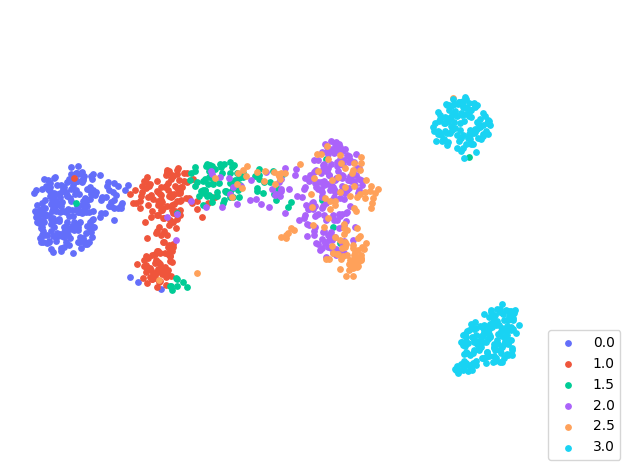

In [42]:
import plotly
colors = plotly.colors.qualitative.Plotly
celltypes = np.sort(list(set(adata.obs['time'])))
celltype_vec = adata.obs['time']
cnt = 0
for celltype in celltypes:
    idx = np.where(celltype_vec == celltype)[0]
    plt.scatter(X_umap[idx,0], X_umap[idx,1], c=colors[cnt], label=celltype, s=15)
    cnt += 1
plt.axis('equal')
plt.axis('off')
plt.grid(False)
plt.legend(loc=[1.01,0])
plt.tight_layout()

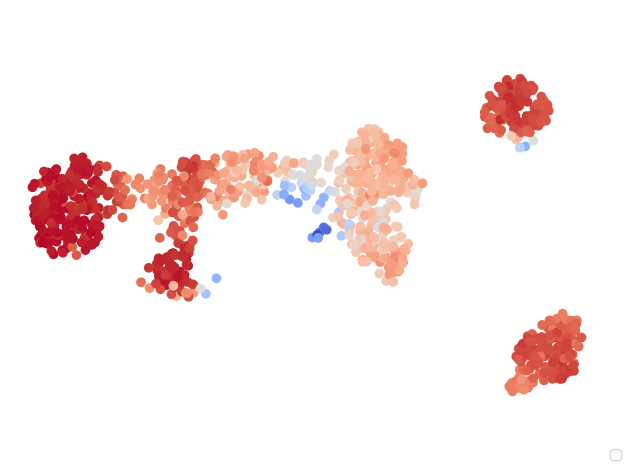

In [43]:
plt.scatter(X_umap[:,0], X_umap[:,1], c=crc_smooth, cmap='coolwarm')
    
plt.axis('equal')
plt.axis('off')
plt.grid(False)
plt.legend(loc=[1.01,0])
plt.tight_layout()

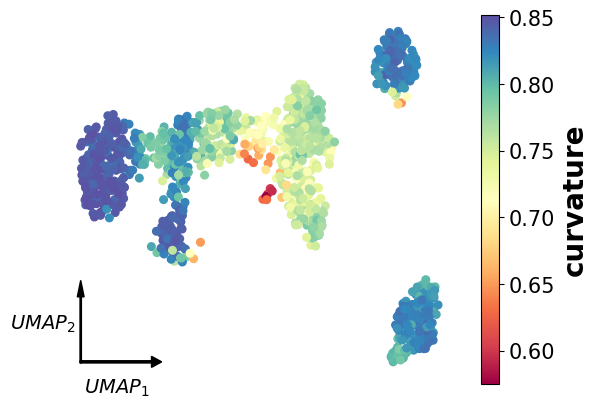

In [47]:
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*28,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+'crc_smooth')
plt.show()


In [45]:
np.save(result_path+'/crc_smooth', crc_smooth)

In [46]:
adata

AnnData object with n_obs × n_vars = 1081 × 96
    obs: 'time', 'leiden'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## 